### Implementation 3.0 of STN: 
There are three components of the STN: 
1) The locazliation network , which takes the image and returns a affine matrix


2)Parameterized sampling grid, which apparently just applies the affine transformation on each pixel. 


3) Differentiable image sampling--> Which is a function that defines where the kernel is applied. In some implenentations, this step seems like it's skipped. One implementation replaces the differentiable image sampling with a bilinear interpolation, which fills 'holes' in the image due to affine trasnformation with an image that is interpolated between adjacent points. 


I will try to implement without this differntaible image sampleing. 


In [318]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import grad,vmap ,jit
from mlxtend.data import loadlocal_mnist
import platform
import matplotlib.pyplot as py

#### Load Data 
$x^2$

In [125]:
if not platform.system() == 'Windows':
    mnist_train_data, mnist_train_labels = loadlocal_mnist(
            images_path='./data/train-images.idx3-ubyte', 
            labels_path='./data/train-labels.idx1-ubyte')

else:
    mnist_train_data, mnist_train_labels = loadlocal_mnist(
            images_path='./data/Cross-Stitch-Jax/train-images.idx3-ubyte', 
            labels_path='./data/Cross-Stitch-Jax/train-labels.idx1-ubyte')
mnist_train_data=mnist_train_data.reshape(60000,28,28)
mnist_train_data=mnist_train_data/255.0

In [63]:
def create_grid (x1,x2,y1,y2):
    featuremap_grid=[]
    for y in range (y1,y2):
        for x in range(x1,x2): 
            featuremap_grid.append((y,x))
    return np.array(featuremap_grid)
                        

In [355]:
affine = jnp.array([[1.0,0],
                   [0,1.0]])
grid= create_grid(0,28,0,28) #[784,2]

## Main functions

In [359]:
#Function will take the transformed sampling grid and apply it to the image. 
def sampling_network (image,transformed_grid): 
    image=image.flatten()
    new_image=np.zeros((28,28))
    transformed_grid=transformed_grid.astype(int)
    for i in range(784): #This is the slowest part! 
        new_image[transformed_grid[i,0]][transformed_grid[i,1]]= image[i]
    return jnp.array(new_image)

def localization_network(affine,initial_grid): 
    #localization_grid=np.tile(jnp.array(affine),(784,1,1))#[784,2,2]
    localization_grid=affine
    return jnp.dot(initial_grid,localization_grid.T)#optimally you want an output of 784,2
#jit_localization_network = jit(localization_network)

def MSE(image,target,affine,initial_grid): 
    new_grid=localization_network(affine,grid)
    pred=sampling_network(image,new_grid)
    pred=pred.flatten()
    target=target.flatten()
    
    return (jnp.sum((target-pred))**2)/784

gradient=grad(MSE,argnums=(2))

In [340]:
new_grid=localization_network(mnist_train_data,affine,grid) #returns [784,2]

TypeError: localization_network() takes 2 positional arguments but 3 were given

In [353]:
new_grid=localization_network(affine,grid)
test_image=sampling_network(mnist_train_data[0],new_grid)



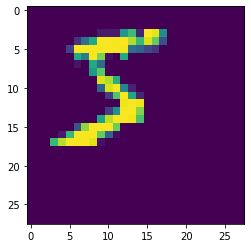

In [354]:
py.imshow(test_image)

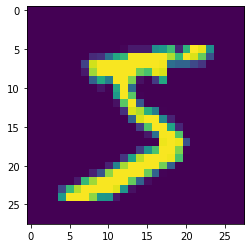

In [349]:
py.imshow(mnist_train_data[0])

In [328]:
image1=mnist_train_data[0].flatten()
test=MSE(image1,image1,affine,grid)


/home/paul/AIprojects/jupytertest/.venv/lib/python3.8/site-packages/jax/_src/lax/lax.py:6126: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [360]:
da=gradient(test_image,mnist_train_data[0],affine,grid)

In [361]:
da

array([[0., 0.],
       [0., 0.]], dtype=float32)

array([0., 0.], dtype=float32)